# Week 4 Lab – Temporal-Difference Learning (SARSA & Q-Learning on CliffWalking-v1)

In this lab, we implement and compare two Temporal-Difference (TD) control algorithms on the `CliffWalking-v1` environment from Gymnasium:

- **SARSA (on-policy TD control)**
- **Q-Learning (off-policy TD control)**

We will:

- Use **ε-greedy exploration** with NumPy-based Q-tables.
- Perform **online TD updates** after each `env.step(...)` (not after whole episodes).
- Run experiments over **multiple random seeds (≥ 30)**.
- Plot **learning curves with 95% confidence intervals**.
- Visualize the **learned value function**, **policy as arrows**, and **sample trajectories**.
- Analyze the behavioral differences between **SARSA (safe path)** and **Q-learning (risky optimal path)**.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


import gymnasium as gym



plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["font.size"] = 12


In [10]:
def epsilon_greedy(Q, state, epsilon, action_space):
    """
    ε-greedy policy for discrete action spaces.
    - With probability ε: choose a random action.
    - With probability 1-ε: choose argmax_a Q(s, a).
    """
    if np.random.rand() < epsilon:
        return action_space.sample()
    else:
        return int(np.argmax(Q[state]))


def set_global_seed(seed):
    """
    Set NumPy seed for reproducibility. Gym will get a seed at env.reset(...).
    """
    np.random.seed(seed)


In [11]:
def train_sarsa(
    num_episodes=500,
    alpha=0.5,
    gamma=0.99,
    epsilon_start=0.1,
    epsilon_min=0.01,
    epsilon_decay=1.0,
    seed=0,
):
    """
    Train SARSA on CliffWalking-v1 for a single seed.
    
    Returns:
        Q: learned Q-table with shape (n_states, n_actions)
        episode_returns: list of total reward per episode
    """
    set_global_seed(seed)
    env = gym.make("CliffWalking-v1")
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    
    Q = np.zeros((n_states, n_actions))
    episode_returns = []
    
    epsilon = epsilon_start
    
    for episode in range(num_episodes):
        # Gymnasium reset returns (obs, info)
        state, info = env.reset(seed=seed + episode)
        done = False
        total_reward = 0.0
        
        # Choose initial action with ε-greedy
        action = epsilon_greedy(Q, state, epsilon, env.action_space)
        
        while not done:
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            total_reward += reward
            
            if not done:
                # Choose next action on-policy
                next_action = epsilon_greedy(Q, next_state, epsilon, env.action_space)
                
                # SARSA TD target: R + γ Q(s', a')
                td_target = reward + gamma * Q[next_state, next_action]
                td_error = td_target - Q[state, action]
                Q[state, action] += alpha * td_error
                
                state = next_state
                action = next_action
            else:
                # Terminal: no bootstrap
                td_target = reward
                td_error = td_target - Q[state, action]
                Q[state, action] += alpha * td_error
        
        # Track episodic return
        episode_returns.append(total_reward)
        
        # ε decay
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
    
    env.close()
    return Q, np.array(episode_returns)


In [12]:
def train_q_learning(
    num_episodes=500,
    alpha=0.5,
    gamma=0.99,
    epsilon_start=0.1,
    epsilon_min=0.01,
    epsilon_decay=1.0,
    seed=0,
):
    """
    Train Q-learning on CliffWalking-v1 for a single seed.
    
    Returns:
        Q: learned Q-table with shape (n_states, n_actions)
        episode_returns: list of total reward per episode
    """
    set_global_seed(seed)
    env = gym.make("CliffWalking-v1")
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    
    Q = np.zeros((n_states, n_actions))
    episode_returns = []
    
    epsilon = epsilon_start
    
    for episode in range(num_episodes):
        state, info = env.reset(seed=seed + episode)
        done = False
        total_reward = 0.0
        
        while not done:
            # ε-greedy behavior policy
            action = epsilon_greedy(Q, state, epsilon, env.action_space)
            
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            total_reward += reward
            
            if not done:
                # Q-learning TD target: R + γ max_a Q(s', a)
                td_target = reward + gamma * np.max(Q[next_state])
            else:
                # Terminal: no bootstrap
                td_target = reward
            
            td_error = td_target - Q[state, action]
            Q[state, action] += alpha * td_error
            
            state = next_state
        
        episode_returns.append(total_reward)
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
    
    env.close()
    return Q, np.array(episode_returns)


In [13]:
def run_multi_seed_experiment(
    algo="sarsa",
    num_seeds=30,
    num_episodes=500,
    alpha=0.5,
    gamma=0.99,
    epsilon_start=0.1,
    epsilon_min=0.01,
    epsilon_decay=1.0,
):
    """
    Run SARSA or Q-learning for multiple seeds and aggregate episode returns.
    
    Returns:
        all_returns: array of shape (num_seeds, num_episodes)
        final_Q: Q-table from the last seed (for visualization)
    """
    all_returns = []
    final_Q = None
    
    for seed in range(num_seeds):
        if algo.lower() == "sarsa":
            Q, returns = train_sarsa(
                num_episodes=num_episodes,
                alpha=alpha,
                gamma=gamma,
                epsilon_start=epsilon_start,
                epsilon_min=epsilon_min,
                epsilon_decay=epsilon_decay,
                seed=seed,
            )
        elif algo.lower() in ["q_learning", "q-learning", "qlearning"]:
            Q, returns = train_q_learning(
                num_episodes=num_episodes,
                alpha=alpha,
                gamma=gamma,
                epsilon_start=epsilon_start,
                epsilon_min=epsilon_min,
                epsilon_decay=epsilon_decay,
                seed=seed,
            )
        else:
            raise ValueError("algo must be 'sarsa' or 'q_learning'")
        
        all_returns.append(returns)
        final_Q = Q  # store last one
    
    all_returns = np.stack(all_returns, axis=0)  # (num_seeds, num_episodes)
    return all_returns, final_Q


In [14]:
def plot_learning_curve_with_ci(all_returns, label, color=None):
    """
    all_returns: shape (num_seeds, num_episodes)
    """
    num_seeds, num_episodes = all_returns.shape
    mean_returns = all_returns.mean(axis=0)
    std_returns = all_returns.std(axis=0, ddof=1)
    ci = 1.96 * std_returns / np.sqrt(num_seeds)
    
    episodes = np.arange(num_episodes)
    plt.plot(episodes, mean_returns, label=label)
    plt.fill_between(episodes, mean_returns - ci, mean_returns + ci, alpha=0.2)
    

def plot_sarsa_vs_qlearning(sarsa_returns, q_returns):
    plt.figure(figsize=(12, 5))
    plot_learning_curve_with_ci(sarsa_returns, label="SARSA")
    plot_learning_curve_with_ci(q_returns, label="Q-learning")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward per Episode")
    plt.title("Learning Curves with 95% Confidence Intervals")
    plt.legend()
    plt.grid(True)
    plt.show()


Running SARSA over 30 seeds...
Running Q-learning over 30 seeds...


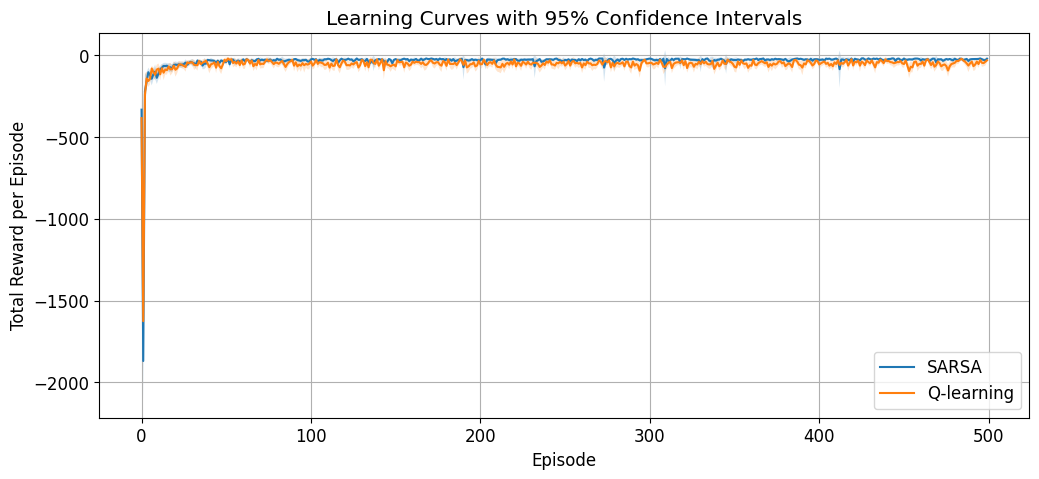

In [ ]:
NUM_SEEDS = 30
NUM_EPISODES = 500

# Baseline hyperparameters 
ALPHA = 0.5
GAMMA = 0.99
EPS_START = 0.1
EPS_MIN = 0.01
EPS_DECAY = 1.0  

print("Running SARSA over", NUM_SEEDS, "seeds...")
sarsa_returns, sarsa_Q = run_multi_seed_experiment(
    algo="sarsa",
    num_seeds=NUM_SEEDS,
    num_episodes=NUM_EPISODES,
    alpha=ALPHA,
    gamma=GAMMA,
    epsilon_start=EPS_START,
    epsilon_min=EPS_MIN,
    epsilon_decay=EPS_DECAY,
)

print("Running Q-learning over", NUM_SEEDS, "seeds...")
q_returns, q_Q = run_multi_seed_experiment(
    algo="q_learning",
    num_seeds=NUM_SEEDS,
    num_episodes=NUM_EPISODES,
    alpha=ALPHA,
    gamma=GAMMA,
    epsilon_start=EPS_START,
    epsilon_min=EPS_MIN,
    epsilon_decay=EPS_DECAY,
)

plot_sarsa_vs_qlearning(sarsa_returns, q_returns)


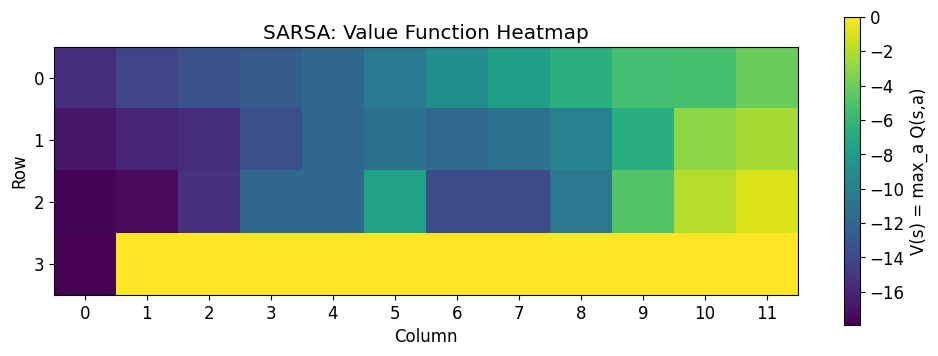

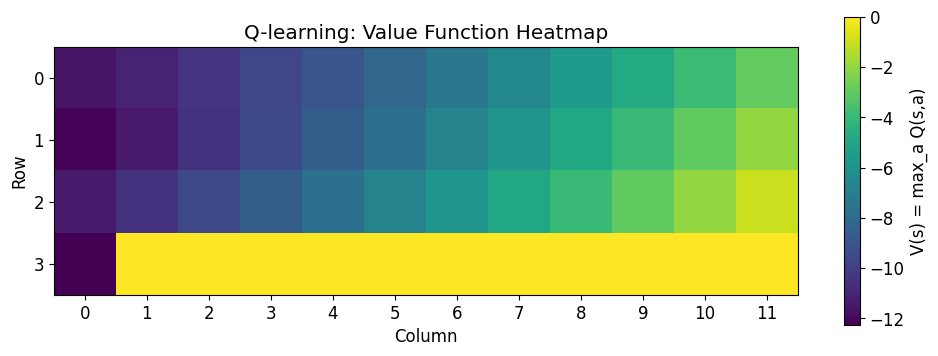

In [17]:
def plot_value_function_heatmap(Q, title="Value Function Heatmap"):
    """
    V(s) = max_a Q(s,a), reshaped into (4, 12) for CliffWalking.
    """
    n_states, n_actions = Q.shape
    assert n_states == 48, "CliffWalking-v1 should have 48 states (4x12)."
    
    V = np.max(Q, axis=1).reshape(4, 12)
    
    plt.figure(figsize=(12, 4))
    plt.imshow(V, origin="upper", interpolation="nearest")
    plt.colorbar(label="V(s) = max_a Q(s,a)")
    plt.title(title)
    plt.xlabel("Column")
    plt.ylabel("Row")
    plt.xticks(range(12))
    plt.yticks(range(4))
    plt.grid(False)
    plt.show()

# Example usage:
plot_value_function_heatmap(sarsa_Q, title="SARSA: Value Function Heatmap")
plot_value_function_heatmap(q_Q, title="Q-learning: Value Function Heatmap")


→ → → → → → → → → → ↓ ↓
↑ ↑ → → ↑ ↑ → ↑ ↑ → ↓ ↓
↑ ↑ ← → ← ← → ← ← ← → ↓
↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑


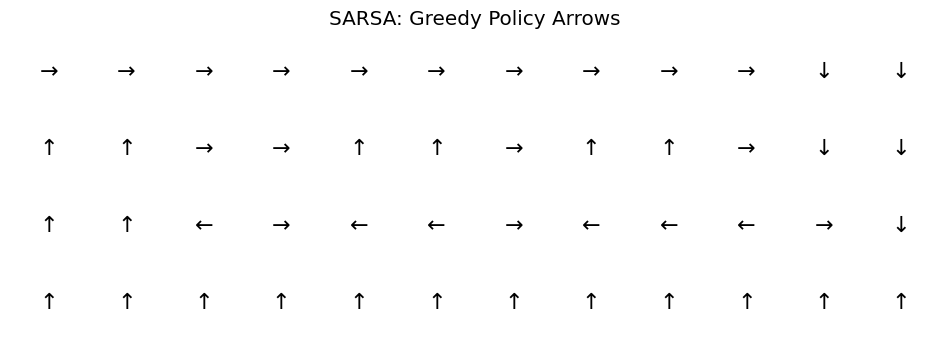

↑ → → → → → ↑ → → → ↓ ↓
↓ → → → → → → → ↓ ↓ ↓ ↓
→ → → → → → → → → → → ↓
↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑


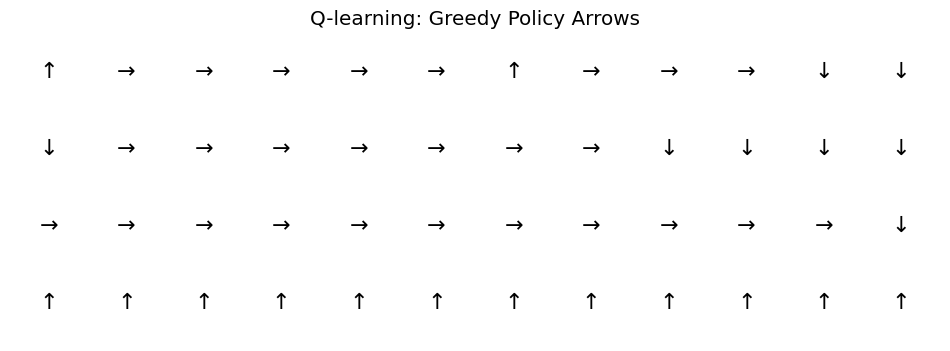

In [ ]:
def plot_policy_arrows(Q, title="Policy (Argmax Q)"):
    """
    Visualize the greedy policy as arrows on the 4x12 grid.
    Action encoding in CliffWalking-v1:
        0: UP, 1: RIGHT, 2: DOWN, 3: LEFT
    """
    n_states, n_actions = Q.shape
    assert n_states == 48, "CliffWalking-v1 should have 48 states."
    
    policy = np.argmax(Q, axis=1).reshape(4, 12)
    action_symbols = {0: "↑", 1: "→", 2: "↓", 3: "←"}
    
    plt.figure(figsize=(12, 4))
    plt.title(title)
    plt.axis("off")
    
    for r in range(4):
        row_symbols = []
        for c in range(12):
            s = r * 12 + c
            symbol = action_symbols[int(policy[r, c])]
            row_symbols.append(symbol)
        print(" ".join(row_symbols))
    
    # Optional: overlay on grid visually
    for r in range(4):
        for c in range(12):
            s = r * 12 + c
            symbol = action_symbols[int(policy[r, c])]
            plt.text(c + 0.5, r + 0.5, symbol, ha="center", va="center", fontsize=16)
    
    plt.xlim(0, 12)
    plt.ylim(4, 0)
    plt.grid(True)
    plt.show()

#  usage:
plot_policy_arrows(sarsa_Q, title="SARSA: Greedy Policy Arrows")
plot_policy_arrows(q_Q, title="Q-learning: Greedy Policy Arrows")


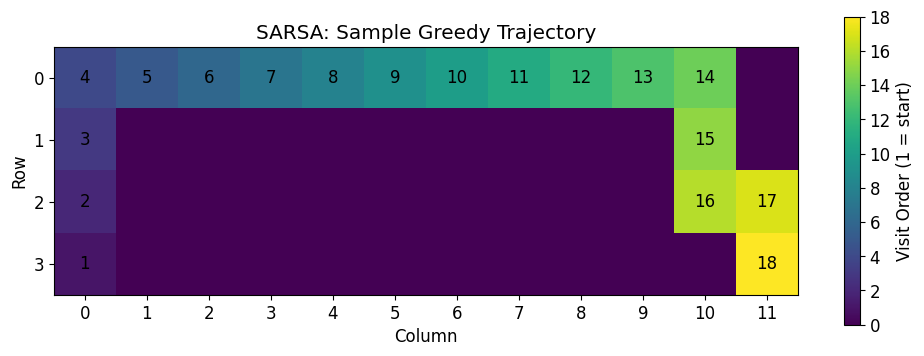

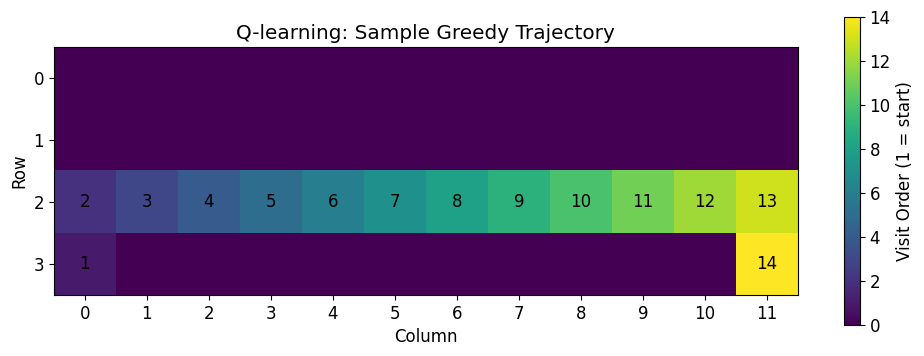

In [20]:
def generate_greedy_trajectory(Q, max_steps=100):
    """
    Run a greedy policy (no exploration) using Q on CliffWalking-v1.
    Returns:
        states: list of state indices visited
    """
    env = gym.make("CliffWalking-v1")
    state, info = env.reset()
    done = False
    states = [state]
    
    steps = 0
    while not done and steps < max_steps:
        action = int(np.argmax(Q[state]))
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        states.append(next_state)
        state = next_state
        steps += 1
    
    env.close()
    return states


def plot_trajectory_on_grid(states, title="Trajectory on Grid"):
    """
    Plot visited states as a path on the 4x12 grid.
    """
    grid = np.zeros((4, 12))
    # mark path order
    for idx, s in enumerate(states):
        r, c = divmod(s, 12)
        grid[r, c] = idx + 1  # step index
    
    plt.figure(figsize=(12, 4))
    plt.imshow(grid, origin="upper", interpolation="nearest")
    plt.colorbar(label="Visit Order (1 = start)")
    plt.title(title)
    plt.xlabel("Column")
    plt.ylabel("Row")
    plt.xticks(range(12))
    plt.yticks(range(4))
    
    # Add text labels
    for r in range(4):
        for c in range(12):
            if grid[r, c] > 0:
                plt.text(c, r, int(grid[r, c]), ha="center", va="center", color="black")
    
    plt.show()

# Generate and plot trajectories
sarsa_traj = generate_greedy_trajectory(sarsa_Q)
q_traj = generate_greedy_trajectory(q_Q)

plot_trajectory_on_grid(sarsa_traj, title="SARSA: Sample Greedy Trajectory")
plot_trajectory_on_grid(q_traj, title="Q-learning: Sample Greedy Trajectory")


## Hyperparameter Experiments

Now we experiment with:

- Different step sizes: **α ∈ {0.1, 0.5}**
- Different exploration schedules:
  - Static ε = 0.1
  - Decaying ε: ε_t = max(0.01, 0.99^t)

You can re-run the experiments by changing:
- `ALPHA`
- `EPS_DECAY`
- `EPS_START`

Then compare:
- Learning speed (how quickly returns improve)
- Stability (variance of learning curves)
- Final performance (average return in last N episodes)


In [21]:
def summarize_performance(all_returns, label, last_n=50):
    """
    Print summary statistics for the last N episodes.
    """
    mean_last = all_returns[:, -last_n:].mean()
    std_last = all_returns[:, -last_n:].std(ddof=1)
    print(f"{label} - Mean return (last {last_n} episodes): {mean_last:.2f} ± {std_last:.2f}")


summarize_performance(sarsa_returns, "SARSA")
summarize_performance(q_returns, "Q-learning")


SARSA - Mean return (last 50 episodes): -26.16 ± 29.62
Q-learning - Mean return (last 50 episodes): -50.84 ± 71.30


In [22]:
def summarize_performance(all_returns, label, last_n=50):
    """
    Print summary statistics for the last N episodes.
    """
    mean_last = all_returns[:, -last_n:].mean()
    std_last = all_returns[:, -last_n:].std(ddof=1)
    print(f"{label} - Mean return (last {last_n} episodes): {mean_last:.2f} ± {std_last:.2f}")


summarize_performance(sarsa_returns, "SARSA")
summarize_performance(q_returns, "Q-learning")


SARSA - Mean return (last 50 episodes): -26.16 ± 29.62
Q-learning - Mean return (last 50 episodes): -50.84 ± 71.30
